# Example: Linear Regression in PyMC

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


### Step 1. Define Model Input

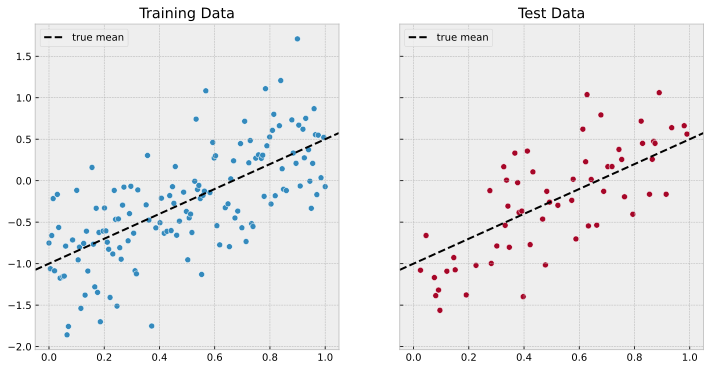

In [2]:
np.random.seed(seed=42)

a_true = -1.0
b_true = 1.5
sigma_true = 0.5
n = 200


def generate_sample_data(a, b, sigma, n):
    x = np.linspace(start=0.0, stop=1, num=n).reshape(n, 1)
    mu_true = a + b * x
    y = np.random.normal(loc=mu_true, scale=sigma, size=(n, 1))
    x_train, x_test, y_train, y_test = [
        x.flatten() for x in train_test_split(x, y, test_size=0.3, random_state=42)
    ]
    y_train = y_train[np.argsort(x_train)]
    x_train = x_train[np.argsort(x_train)]
    y_test = y_test[np.argsort(x_test)]
    x_test = x_test[np.argsort(x_test)]

    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = generate_sample_data(
    a=a_true, b=b_true, sigma=sigma_true, n=n
)

n_train = x_train.shape[0]
n_test = x_test.shape[0]

idx_train = range(n_train)
idx_test = range(n_train, n_train + n_test)

#w_train = np.ones(shape=n_train)
#w_test = np.ones(shape=n_test)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)
sns.scatterplot(x=x_train, y=y_train, color="C0", ax=ax[0])
sns.scatterplot(x=x_test.squeeze(), y=y_test, color="C1", ax=ax[1])
ax[0].axline(
    xy1=(0, a_true), slope=b_true, color="black", linestyle="--", label="true mean"
)
ax[1].axline(
    xy1=(0, a_true), slope=b_true, color="black", linestyle="--", label="true mean"
)
ax[0].legend(loc="upper left")
ax[1].legend(loc="upper left")
ax[0].set(title="Training Data")
ax[1].set(title="Test Data");


### Step 2. Model Specification

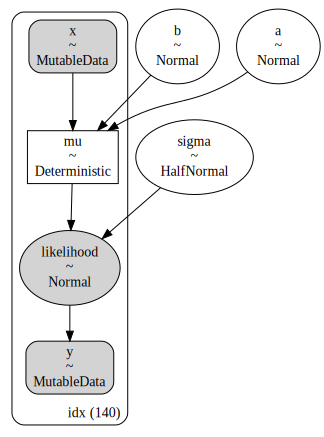

In [3]:
with pm.Model() as model:
    # --- Data Containers ---
    model.add_coord(name="idx", values=idx_train, mutable=True)
    x = pm.MutableData(name="x", value=x_train,dims="idx")
    y = pm.MutableData(name="y", value=y_train, dims="idx")
    # weights = pm.MutableData(name="weights", value=w_train, dims="idx")
    # --- Priors ---
    a = pm.Normal(name="a", mu=0, sigma=2)
    b = pm.Normal(name="b", mu=0, sigma=2)
    sigma = pm.HalfNormal(name="sigma", sigma=2)
    # --- Model Parametrization ---
    mu = pm.Deterministic(name="mu", var=a + b * x, dims="idx")
    # sigma_weighted = sigma / weights
    # --- Likelihood ---
    likelihood = pm.Normal(
        name="likelihood", mu=mu, sigma=sigma, observed=y, dims="idx"
    )

pm.model_to_graphviz(model=model)

### 3. Prior Predictive Checks

In [4]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=100)

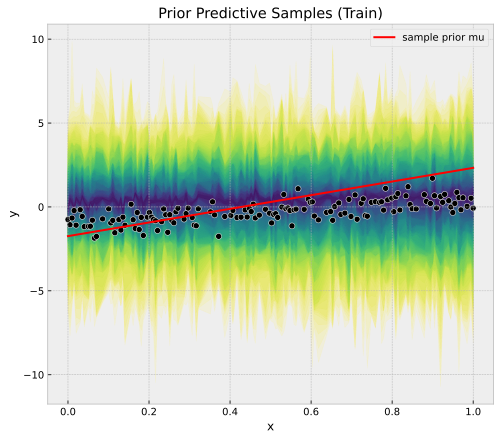

In [5]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots(figsize=(8, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(prior_predictive.prior_predictive["likelihood"], p, axis=1)
    lower = np.percentile(
        prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=x_train,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )
sns.lineplot(
    x=x_train,
    y=prior_predictive.prior["mu"][0, 0, :],
    color="red",
    label="sample prior mu",
    ax=ax,
)
sns.scatterplot(
    x=x_train,
    y=y_train,
    color="black",
    ax=ax,
)
ax.set(title="Prior Predictive Samples (Train)", xlabel="x", ylabel="y");


### 4. Fit Model

In [6]:
# via sklearn
lr = LinearRegression()
lr.fit(X=x_train[..., np.newaxis], y=y_train[..., np.newaxis])
y_pred_train = lr.predict(x_train[..., np.newaxis])
y_pred_test = lr.predict(x_test[..., np.newaxis])

In [7]:
with model:
    idata = pm.sample(
        target_accept=0.95, draws=1_000, chains=4
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


###  5. Model Diagnostics

In [8]:
var_names = ["a", "b", "sigma"]
var_names = ["~mu", "~chol_cov_corr"]

In [9]:
az.summary(data=idata, var_names=var_names)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/arviz/utils.py:136: UserWarning: Items starting with ~: ['chol_cov_corr'] have not been found and will be ignored
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a     -1.034  0.080  -1.183   -0.887      0.002    0.001    1550.0    1675.0   
b      1.517  0.136   1.264    1.777      0.003    0.002    1601.0    1942.0   
sigma  0.481  0.030   0.428    0.537      0.001    0.000    2042.0    1866.0   

       r_hat  
a        1.0  
b        1.0  
sigma    1.0

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/arviz/utils.py:136: UserWarning: Items starting with ~: ['chol_cov_corr'] have not been found and will be ignored
  warnings.warn(


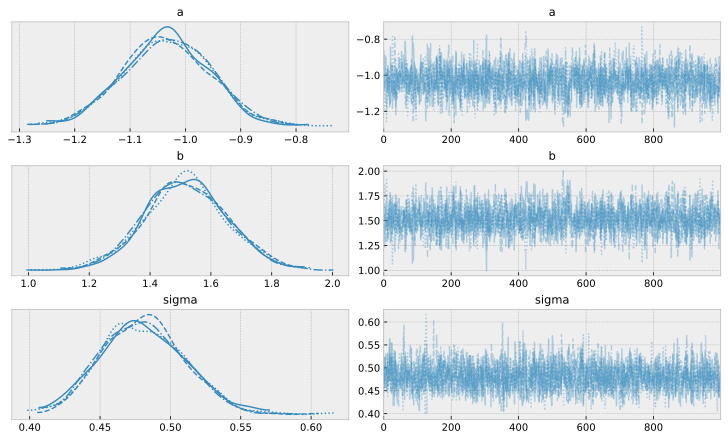

In [10]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    #lines=[("a", {}, [a_true]),("b", {}, [b_true]), ("sigma", {}, [sigma_true])],
    compact=True,
    backend_kwargs={"figsize": (10, 6), "layout": "constrained"},
)

### 6. Posterior Predictive (Train)

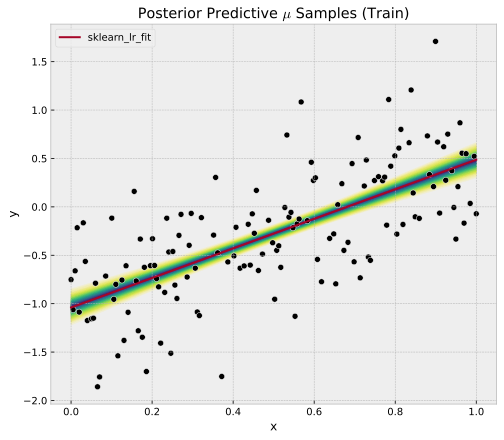

In [11]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_mu_train = idata.posterior["mu"].stack(sample=("chain", "draw"))

fig, ax = plt.subplots(figsize=(8, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_mu_train, p, axis=1)
    lower = np.percentile(posterior_predictive_mu_train, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=x_train,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.scatterplot(x=x_train,y=y_train,color="black", ax=ax)
sns.lineplot(x=x_train,y=y_pred_train.ravel(), color="C1", label="sklearn_lr_fit", ax=ax)
ax.legend(loc="upper left")
ax.set(title="Posterior Predictive $\mu$ Samples (Train)", xlabel="x", ylabel="y");


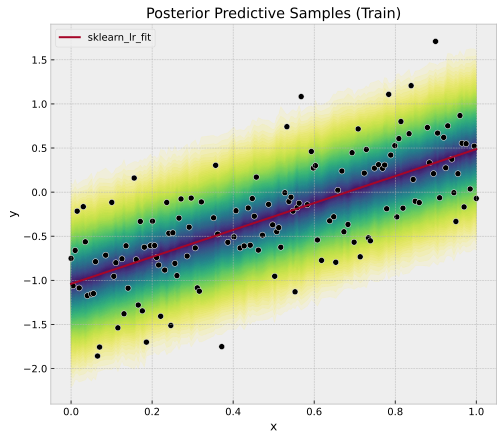

In [12]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_likelihood_train = posterior_predictive.posterior_predictive[
    "likelihood"
].stack(sample=("chain", "draw"))

fig, ax = plt.subplots(figsize=(8, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_train, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_train, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=x_train,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.scatterplot(x=x_train,y=y_train,color="black",ax=ax)
sns.lineplot(x=x_train,y=y_pred_train.ravel(), color="C1", label="sklearn_lr_fit", ax=ax)
ax.legend(loc="upper left")
ax.set(title="Posterior Predictive Samples (Train)", xlabel="x", ylabel="y");


### 7. Posterior Predictive (Test)

In [13]:
with model:
    pm.set_data(new_data={"x": x_test, "y": y_test}, coords={"idx": idx_test})
    idata.extend(
        other=pm.sample_posterior_predictive(
            trace=idata,
            var_names=["likelihood", "mu"],
            idata_kwargs={"coords": {"idx": idx_test}},
        ),
        join="right",
    )


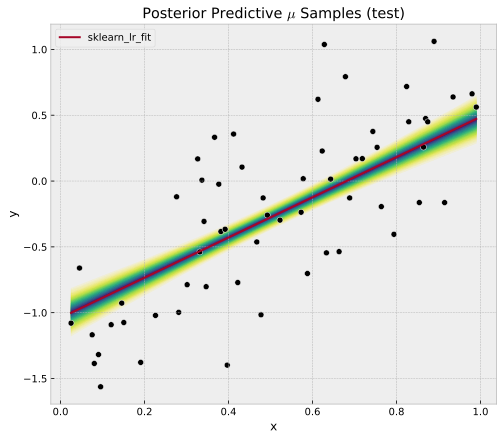

In [14]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_mu_test = idata.posterior_predictive["mu"].stack(sample=("chain", "draw"))

fig, ax = plt.subplots(figsize=(8, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_mu_test, p, axis=1)
    lower = np.percentile(posterior_predictive_mu_test, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=x_test,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.scatterplot(x=x_test,y=y_test,color="black", ax=ax)
sns.lineplot(x=x_test,y=y_pred_test.ravel(), color="C1", label="sklearn_lr_fit", ax=ax)
ax.legend(loc="upper left")
ax.set(title="Posterior Predictive $\mu$ Samples (test)", xlabel="x", ylabel="y");

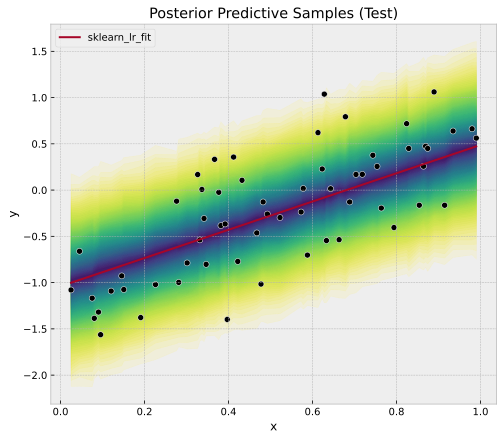

In [15]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_likelihood_test = idata.posterior_predictive["likelihood"].stack(
    sample=("chain", "draw")
)

fig, ax = plt.subplots(figsize=(8, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_test, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_test, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=x_test,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.scatterplot(x=x_test,y=y_test,color="black", ax=ax)
sns.lineplot(x=x_test,y=y_pred_test.ravel(), color="C1", label="sklearn_lr_fit", ax=ax)
ax.legend(loc="upper left")
ax.set(title="Posterior Predictive Samples (Test)", xlabel="x", ylabel="y");

---

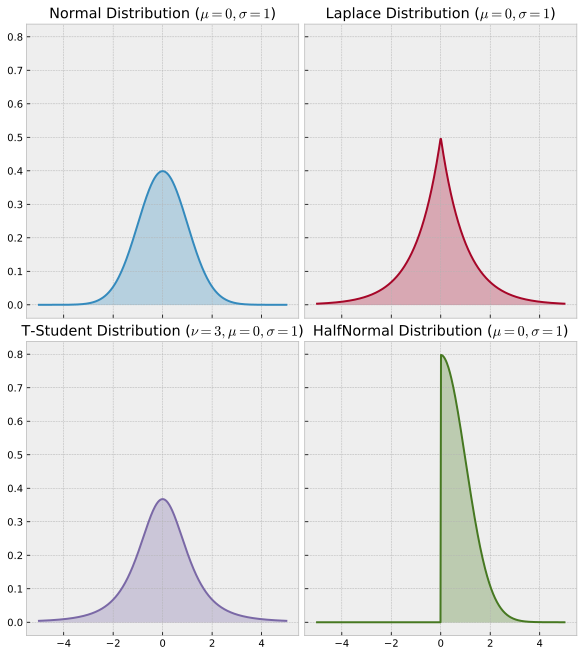

In [16]:
import scipy.stats

x = np.linspace(-5, 5, 500)

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(8, 9), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(
    x=x, y=scipy.stats.norm.pdf(x=x, loc=0.0, scale=1), color="C0", ax=axes[0, 0]
)
axes[0, 0].fill_between(
    x, 0, scipy.stats.norm.pdf(x=x, loc=0.0, scale=1), color="C0", alpha=0.3
)
axes[0, 0].set(title="Normal Distribution ($\mu=0, \sigma=1$)")
sns.lineplot(
    x=x, y=scipy.stats.laplace.pdf(x=x, loc=0.0, scale=1), color="C1", ax=axes[0, 1]
)
axes[0, 1].fill_between(
    x, 0, scipy.stats.laplace.pdf(x=x, loc=0.0, scale=1), color="C1", alpha=0.3
)
axes[0, 1].set(title="Laplace Distribution ($\mu=0, \sigma=1$)")
sns.lineplot(
    x=x, y=scipy.stats.t.pdf(x=x, df=3, loc=0.0, scale=1), color="C2", ax=axes[1, 0]
)
axes[1, 0].fill_between(
    x, 0, scipy.stats.t.pdf(x=x, df=3, loc=0.0, scale=1), color="C2", alpha=0.3
)
axes[1, 0].set(title="T-Student Distribution ($\\nu=3, \mu=0, \sigma=1$)")
sns.lineplot(
    x=x, y=scipy.stats.halfnorm.pdf(x=x, loc=0.0, scale=1), color="C3", ax=axes[1, 1]
)
axes[1, 1].fill_between(
    x, 0, scipy.stats.halfnorm.pdf(x=x, loc=0.0, scale=1), color="C3", alpha=0.3
)
axes[1, 1].set(title="HalfNormal Distribution ($\mu=0, \sigma=1$)");


In [17]:
# https://www.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html?highlight=radon#varying-intercept-and-slope-model
# import aesara.tensor as at

# with pm.Model() as model:
#     # --- Data Containers ---
#     model.add_coord(name="idx", values=idx_train, mutable=True)
#     x = pm.MutableData(name="x", value=x_train, dims="idx")
#     y = pm.MutableData(name="y", value=y_train, dims="idx")
#     # weights = pm.MutableData(name="weights", value=w_train, dims="idx")
#     # --- Priors ---
#     chol, corr, stds = pm.LKJCholeskyCov(
#         name="chol_cov", n=2, eta=1, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
#     )
#     sigma = pm.HalfNormal(name="sigma", sigma=2)
#     # --- Model Parametrization ---
#     ab = pm.MvNormal(name="ab", mu=at.zeros(2), chol=chol)
#     x_transpose = at.expand_dims(x, axis=0)
#     x_ext = at.concatenate([x_transpose, at.ones_like(x_transpose)], axis=0)
#     mu = pm.Deterministic(name="mu", var=at.dot(ab, x_ext), dims="idx")
#     # # sigma_weighted = sigma / weights
#     # # --- Likelihood ---
#     likelihood = pm.Normal(
#         name="likelihood", mu=mu, sigma=sigma, observed=y, dims="idx"
#     )

# with pm.Model() as model:
#     # --- Data Containers ---
#     model.add_coord(name="idx", values=idx_train, mutable=True)
#     x = pm.MutableData(name="x", value=x_train, dims="idx")
#     y = pm.MutableData(name="y", value=y_train, dims="idx")
#     # weights = pm.MutableData(name="weights", value=w_train, dims="idx")
#     # --- Priors ---
#     a = pm.Normal(name="a", mu=0, sigma=2)
#     b = pm.Normal(name="b", mu=0, sigma=2)
#     chol, corr, stds = pm.LKJCholeskyCov(
#         name="chol_cov", n=2, eta=1, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
#     )
#     z = pm.Normal(name="z", mu=0, sigma=1, shape=2)
#     sigma = pm.HalfNormal(name="sigma", sigma=2)
#     # --- Model Parametrization ---
#     mu = pm.Deterministic(name="mu", var=a + at.dot(chol, z)[0] + (b + at.dot(chol, z)[1]) * x, dims="idx")
#     # sigma_weighted = sigma / weights
#     # --- Likelihood ---
#     likelihood = pm.Normal(
#         name="likelihood", mu=mu, sigma=sigma, observed=y, dims="idx"
#     )
